In [28]:
from tabulate import tabulate
import time
import random
from random import randint
from IPython.display import Image
random.seed(42) # for reproducibility

# Dynamic programming

Dynamic programming is similar to the divide and conquer approach except that the subproblems overlap i.e. the subproblems share the same sub-subproblems. This method of solving problems typically is used in optimization problems, particularly optimal control problems, and was originally developed by Richard E. Bellman who is also famous for developing the closely related Bellman equation which is at the core of reinforcement learning {cite:p}`sutton2018reinforcement`.

The key strategy is to store the solutions, in a hashtable for example, to the subproblems and then reuse the solution later if the same subproblem is encountered rather than recomputing the solution {cite:p}`cormen2022introduction`. Computing the $n$-th Fibonacci number is a common example problem that illustrates this. This is a crucial distinction between dynamic programming versus divide and conquer: in the former the subproblems may overlap or appear multiple times and we can exploit this redundancy by storing solutions to these subproblems to reuse when we encounter them later on in the process of solving the problem.

## Bottom-up versus top-down approaches

There are two approaches to solving dynamic programming problems: bottom-up and top-down {cite:p}`cormen2022introduction`. The top-down approach involves writing the algorithm recursively and utilizing *memoization* (which we go over later).  The bottom-up approach does not utilize recursion, and thus usually has better constant factors for complexity since we avoid the time and space overhead of multiple function calls, but instead solves the "smallest" subproblems first and uses those solutions to construct solutions to the next largest subproblems until the overall problem is solved. 

## $n$-th Fibonacci number

Here we'll go over a simple example that demonstrates the power of dynamic programming, along with the difference in the two approaches, by computing the $n$-th Fibonacci number.

The $n$-th Fibonacci number $F_n$ is defined as

$$
F_n = F_{n-1} + F_{n-2}
$$

where the $0$-th and $1$-st Fibonacci number are defined as $F_0=0$ and $F_1=1$ respectively. This has a clear, albeit naive, recursive implementation in code shown below.

In [29]:
"""
n: the n-th Fibonacci number desired
"""
def naive_fibonacci(n):
    if n == 0:
       return 0
    elif n == 1:
       return 1
    else:
       Fn = naive_fibonacci(n - 1) + naive_fibonacci(n - 2)
       return Fn
   
start_time = time.time()
n = 35
print(f"{n}-th Fibonacci number is: {naive_fibonacci(n)}")
print(f"Took {(time.time() - start_time):.3f} seconds")

35-th Fibonacci number is: 9227465
Took 2.426 seconds


The implementation is naive because of the two recursive calls `naive_fibonacci(n - 1)` and `naive_fibonacci(n - 2)`. For example when $n=10$ the first recursive call computes $F_9$ and the second recursive call computes $F_8$. However to compute $F_9$ the first recursive call is going to need to compute $F_8$ but wait, $F_8$ is already being computed by the *second* recursive call. This means we're doing double the work and it only gets worse as $n$ increases! We can get around this by *storing* the solutions to smaller Fibonacci problems in a hashtable/dict that we have already computed and when we need to compute them again we can simply look up the solution in the table. This is called ***memoization*** and is the key distinction between dynamic programming versus divide & conquer approaches.

```{note}
:class: dropdown
Note this isn't a typo; it's actually spelled *memoization* and refers to the idea of memos since we store the value and look back at it later {cite:p}`cormen2022introduction`. In my opinion *memorization* would also work just as well since we are memorization the solution to a problem.
```

In [30]:
def fast_fibonacci_top_down(n, memo):
    if n in memo.keys():
       return memo[n]
    if n == 0:
       return 0
    elif n == 1:
       return 1
    else:
       Fn = fast_fibonacci_top_down(n - 1, memo) + fast_fibonacci_top_down(n - 2, memo)
       memo[n] = Fn
       return Fn

start_time = time.time()
memo = {} # for memoization 
print(f"{n}-th Fibonacci number is: {fast_fibonacci_top_down(n, memo)}")
print(f"Took {(time.time() - start_time):.3f} seconds")

35-th Fibonacci number is: 9227465
Took 0.000 seconds


We can also solve this without memoization using the bottom-up approach. In this case we simply solve the smallest subproblems, which in this case is finding the value of $F_2$, first and then use that solution along with the solution to the previous "smallest" subproblem, i.e. finding the value of $F_1$, to find the solution of the next largest subproblem i.e. finding the value of $F_3$.

In [31]:
def fast_fibonacci_bottom_up(n):
    Fn_2 = 0 # F_{n-2}
    Fn_1 = 1 # F_{n-1}
    Fn = 0 # F_n
    for i in range(2, n+1):
        Fn = Fn_1  + Fn_2
        Fn_2 = Fn_1 
        Fn_1 = Fn
    
    return Fn

start_time = time.time()
print(f"{n}-th Fibonacci number is: {fast_fibonacci_bottom_up(n)}")
print(f"Took {(time.time() - start_time):.3f} seconds")

35-th Fibonacci number is: 9227465
Took 0.000 seconds


This method has time complexity $O(n)$ but a space complexity of $O(1)$ since we do not utilize an array to store all $n$ solutions to smaller subproblems.

## Rod cutting

Let's go over the first example of an application of dynamic programming from {cite:p}`cormen2022introduction`.

Suppose we have a rod of length $n \in \mathbb{Z^+}$ and we can sell the rod for a price $p_n$ which is the cash we get for selling a rod of length $n$. We can *also* cut the rod into $k$ parts of integer length $c_i$ such that (obviously)

$$
\begin{align*}
n = c_1 + c_2 + \dots + c_k \quad \text{where $c_i \in \mathbb{Z^+}$}
\end{align*}
$$

and sell each part for the revenue $r_n = p_{c_1} + p_{c_2} + \dots + p_{c_k}$ where again $p_{c_i}$ is the cash we get for selling a rod of integer length $c_i$. The caveat here is that there maybe certain ways to cut the rod such that we actually get more revenue by selling the individually cut pieces instead of selling the uncut rod. 
Clearly this depends on the pricing for each length of rod.  Can we devise an algorithm that, given the length $n$ of the rod along with the prices $p_1, p_2,\dots, p_n$ for selling a rod of length $1, 2, \dots, n$ respectively, finds an (as there could be more than one I think) optimal way of cutting the rod such that we net the highest revenue?

### Top-down approach 

{cite:p}`cormen2022introduction` uses a top-down approach so I will go over that first.

#### Mathematical reasoning for solution

Suppose that an optimal way of cutting the rod (optimal integer decomposition of $n$) cuts the rod into $k$ pieces for some integer $1 \leq k \leq n$. We denote this optimal decomposition as

$$
n_{\text{opt}} = c_1 + c_2 + \dots + c_k
$$

where $c_i$ is the length of the $i$-th segment of the rod. The corresponding optimal revenue is thus

$$
r_{n_{\text{opt}}} = p_{c_1} + p_{c_2} + \dots + p_{c_k}.
$$

In general we can write the optimal revenue $r_{n_{\text{opt}}}$ in terms of optimal revenues for rods of shorter length

$$
r_{n_{\text{opt}}} = \max\left(p_n, r_{1_{\text{opt}}} + r_{(n-1)_{\text{opt}}}, r_{2_{\text{opt}}} + r_{(n-2)_{\text{opt}}}, \dots, r_{(n-1)_{\text{opt}}} + r_{1_{\text{opt}}} \right)
$$

where $p_n$ is the revenue gained from selling the uncut rod of length $n$. The other $n-1$ arguments to $\max$ correspond to the revenue gained from cutting the rod into two pieces of size $i$ and $n-i$ respectively $\forall i \in \{1,2,\dots,n-1\}$ and then optimally cutting up the two resulting pieces of the rod further.

If you think about it it makes sense that the optimal solution for this problem can be achieved by combining optimal solutions of smaller problems. Specifically, when you start with the uncut rod the two options are either 
1) the uncut rod is already optimal to sell 

$\qquad \qquad \qquad \Large{\textbf{or}}$

2) there is a way to cut it to get more revenue in which case you know you have to cut it into ***at least*** two pieces. 

If the second option is chosen then after that point you have two new rods which you need to find the optimal cutting/decomposition of and you simply repeat the previous step again for each rod. The problem here is you need to cut the rod into two pieces in ***every*** possible way since you don't know ahead of time which way of cutting the rod into two pieces (i.e. which value of $i$) is optimal hence all the $n-1$ arguments to $\max$. Doing this naively would result in a time complexity of $O(2^n)$ but with dynamic programming we can reduce this time **exponentially**.

```{note}
:class: dropdown
Where do we get the $O(2^n)$ complexity from? It comes from the number of ways we can cut up the rod. It helps if we think of this in terms of integer compositions. For an integer $n$ a composition is a way of writing $n$ as a sum of *positive* integers i.e. integers greater than $0$. For example for  the number 3 the  possible compositions are $1+1+1$, $2+1$, $1+2$ and $3$. It is clear that the number of compositions of the integer $n$ are exactly equal to the number of ways we can cut up a rod of length $n$. So how can we derive the number of compositions of an integer $n$? From elementary combinatorics we know that the number of compositions of $n$ into exactly $j$ parts is ${n-1 \choose j-1}$. To get the total number of compositions we can simply sum all values of $j$ from $1$ to $n$ and using the binomial theorem.

\begin{align}
2^{n-1} &= (1+1)^{n-1} \\
&= \sum^{n-1}_{k=0}{n-1 \choose k} 1^{n-1-k}1^{k} \\
&= \sum^{n-1}_{k=0}{n-1 \choose k} \\
&\text{Re-index the summation with $k=j-1$ so lower bound becomes $j-1=0\rightarrow j=1$ and upper bound becomes $j-1=n-1\rightarrow j=n$} \\
&=\sum^{n}_{j=1}{n-1 \choose j-1} \qquad \blacksquare
\end{align}

```

We can simplify the general equation for $r_{n_{\text{opt}}}$ a bit more by noticing that in the argument to $\max$ we are actually double counting cases i.g. we have both $r_{1_{\text{opt}}} + r_{(n-1)_{\text{opt}}}$ and $r_{(n-1)_{\text{opt}}} + r_{1_{\text{opt}}}$ being counted. Instead we can just consider each case without it's reverse, since it doesn't matter which of the two new rods we cut up in a certain way (addition is commutative), and we can get the more simple formula


$$
\begin{align*}
r_{n_{\text{opt}}} &= \max\left(p_n, r_{1_{\text{opt}}} + r_{(n-1)_{\text{opt}}}, r_{2_{\text{opt}}} + r_{(n-2)_{\text{opt}}}, \dots, r_{(n-\frac{n}{2})_{\text{opt}}} + r_{{\frac{n}{2}}_{\text{opt}}} \right) \\
&= \max\left(p_{i} + r_{(n-i)_{\text{opt}}}\right) \quad \text{$\forall i \in \{1,2,\dots,n\}$} 
\end{align*}
$$

When a problem can be solved like this by breaking it onto smaller parts, solving those smaller parts independently, and then combining those solutions to those smaller parts we say the problem exhibits **optimal sub-structure**.

Below is some recursive code that solves this problem 

In [32]:
"""
p: A dict where the keys are the length of the rod and the value is the revenue gained from selling a rod of that length

n: The (integer) length of the rod
"""
def naive_rod_cutting(p, n):
    if n == 0: # if rod is length 0 terminate and get 0 revenue (recursive termination condition)
       return 0
    
    max_rev = float('-inf') # initially set revenue to lowest possible number
    
    for i in range(1, n+1): # loop over each possible first cut into two parts
        max_rev = max(max_rev, p[i] + naive_rod_cutting(p, n-i)) 
    
    return max_rev

start_time = time.time()
n = 24
p = {  i:[i*randint(1, i)]  for i in range(1, n+1)  } # generate some random test case, make each item a list b/c tabulate requires it
print(f"Test case table of rod lengths 1 to {n} (top row) and corresponding revenues for selling (bottom row):")
print(tabulate(p, headers='keys', tablefmt='fancy_grid'))
p = {  k:p[k][0]  for k in p.keys()  }
print(f"Max revenue for rod of length {n} is:", naive_rod_cutting(p, n))
print(f"Took {(time.time() - start_time):.3f} seconds")

Test case table of rod lengths 1 to 24 (top row) and corresponding revenues for selling (bottom row):
╒═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤═════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╤══════╕
│   1 │   2 │   3 │   4 │   5 │   6 │   7 │   8 │   9 │   10 │   11 │   12 │   13 │   14 │   15 │   16 │   17 │   18 │   19 │   20 │   21 │   22 │   23 │   24 │
╞═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪═════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╪══════╡
│   1 │   2 │   9 │  12 │  10 │  12 │  14 │  16 │  81 │   20 │  110 │   84 │   13 │   14 │   30 │  112 │  136 │  306 │   19 │  360 │  147 │  462 │  529 │  432 │
╘═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧═════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╧══════╛
Max revenue for rod of length 24 is: 530
Took 4.822 seconds


Now this code works but there is a big issue. For large values of $n$ this code will take a vey long time to run. This makes sense if we think of this in terms of a recursion tree. Below we have an example from {cite:p}`cormen2022introduction` of the recursion tree for `naive_rod_cutting` for $n=4$. So we have the initial call to the function with $n=4$ now what happens once we get to the `for` loop? The function is called recursively at *each* iteration of the loop. During the first iteration we call the function recursively with $n=3$ which can be seen in the leftmost branch of the tree connected to the root. But wait this recursive call *will also loop over all integers that are less than $n=3$* and recursively call itself at each iteration again and so on for those recursive calls until the base case of $n=0$ is reached. More interestingly from the recursion tree we can see that we are calling the function with the same value of $n$ multiple times. For example we call the function with $n=2$ two times and with $n=1$ four times. So not only are we exhaustively looking at each possible way of cutting the rod we are also recomputing the solutions for different values of $n$ over and over again.   

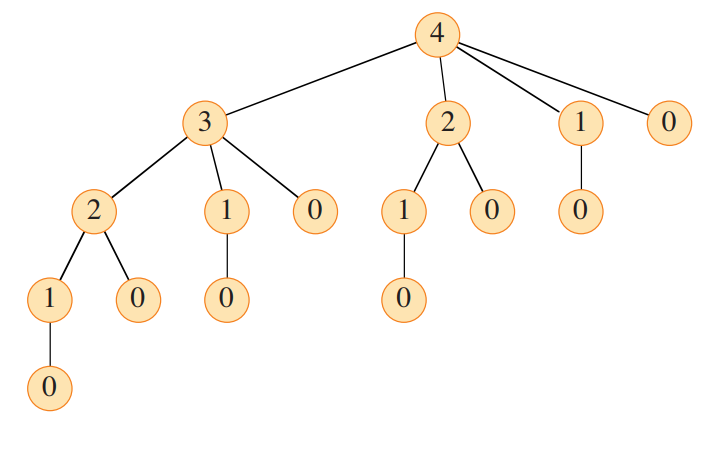

In [33]:
display(Image("img/rod_cut_recursion_tree.png", width=600))

Now instead of solving the same subproblem over and we can instead *store* the solution to a subproblem, in this case the optimal revenue one can get for a rod of length $n' < n$, in a hashtable and then when we come across that subproblem again we can retrieve this solution from the hashtable instead of recomputing a problem we've already solved.

A more efficient version of the `naive_rod_cutting` algorithm, which utilizes memoization, is given below. This algorithm brings the time complexity from $O(2^n)$ to $O(n^2)$ so an exponential speedup! Although note that this comes with the cost of increasing the space complexity from $O(1)$ to $O(n)$ since we are storing a solution for each of the values of rod length that are $< n$.

In [34]:
def fast_rod_cutting_top_down(p, n, memo):
   if n in memo.keys(): # check memo to see if we've already solved this problem for this value of n
      max_rev = memo[n]
      return max_rev

   if n == 0: # if rod is length 0 terminate and get 0 revenue (recursive termination condition)
      return 0
    
   max_rev = float('-inf') # initially set revenue to lowest possible number
    
   for i in range(1, n+1): # loop over each possible first cut into two parts
      max_rev = max(max_rev, p[i] + fast_rod_cutting_top_down(p, n-i, memo))
   
   memo[n] = max_rev # save max revenue found for this value of n
    
   return max_rev

start_time = time.time()
memo = {} # for memoization 
print(f"Max revenue for rod of length {n} is:", fast_rod_cutting_top_down(p, n, memo))
print(f"Took {(time.time() - start_time):.3f} seconds")

Max revenue for rod of length 24 is: 530
Took 0.000 seconds


### Bottom-up approach

For the bottom-up approach we can state the recurrence relation and base case as

$$
\text{Base case:} \quad r_1^{opt} = p_1 \\ \\
\text{Recurrence:} \quad r_i^{opt} = \max\left\{ \max_j\left\{ r_j^{opt} + p_{i-j} \right\}, \quad p_i \right\} \quad \text{where} \quad 1 \leq i \leq n, 1 \leq j < i 
$$

This recurrence can be read as saying: For a rod of length $i$ the maximum revenue attainable will be either the revenue from selling the whole uncut rod ***or*** the revenue from cutting it into a rod of length $i-j$ and selling that and cutting the other part of the rod, which is of length $j$, into the optimal set of pieces for a rod of length $j$ and selling those. Since $j$ is smaller than $i$ this is a smaller subproblem we have solved before and we can therefore just use the solution to that problem to solve this problem. See how much easier this was to understand than top-down?

In [35]:
def fast_rod_cutting_bottom_up(p, n):
    sol = [ p[i] for i in range(1, n+1) ] # set baseline solutions to just be the revenue for selling the whole rod of length i

    for i in range(1, n):
        for j in range(i): # note the +1 in the p indices are due to fact that the keys of p start at 1 and not 0
            if sol[i] < sol[j] + p[i-j]:
               sol[i] = sol[j] + p[i-j]
    
    return sol[-1]

start_time = time.time()
print(f"Max revenue for rod of length {n} is:", fast_rod_cutting_bottom_up(p, n) )
print(f"Took {(time.time() - start_time):.3f} seconds")

Max revenue for rod of length 24 is: 530
Took 0.000 seconds


In my opinion the bottom up approach is much simpler to understand. For example, it is much clearer to see why the time complexity of this algorithm is $O(n^2)$ then it is for the top-down algorithm. 

## Longest increasing subsequence

This was the first problem covered in lecture. The problem can be state as follows. Given a sequence of numbers 

$$
L_n=a_1,a_2,...a_n
$$ 

how can we find the length $L_n^s$ of the longest increasing subsequence (LIS)? A subsequence is any subset of this sequence that preservers the relative ordering of the elements in the original sequence. For example $a_1,a_2,a_3$ is a subsequence as is $a_3, a_4, a_7$ but not $a_3, a_2, a_5$. An increasing subsequence is a subsequence where each element $a_i$ is strictly greater than the previous term in the sequence so 

$$
a_i < a_{i+1} < ... < a_j.
$$

### Potential solution

Thinking of this in terms of dynamic programming we may think to take the bottom-up approach to find the length of the LIS. That is we first find the length of the LIS for the smallest subproblem 

$$
L_1=a_1
$$ 
and then use that solution to compute the length of the LIS for the next largest subproblem 

$$
L_2=a_1,a_2
$$ 

and so on until we compute the length of the LIS for the full sequence $L_n$. Note that for the case of $L_1$ the solution is trivial: the LIS for a sequence with one element is always just that one element which has length $L_1^s=1$.

Let's use the specific example from lecture 

$$
L_{n=12} = 5,7,4,-3,9,1,10,4,5,8,9,3.
$$

So the smallest subproblem is $L_1=5$ for which the LIS is $5$ and the solution is thus $L_1^s=1$. The next smallest subproblem is $L_2=5,7$. Using the previous solution we can just check to see if the newly added element, $7$, is strictly greater than the last element in the LIS for the previous subproblem. If it is then we append that element to the end of the LIS for the previous subproblem and add $1$ to the solution of the previous problem. If it is not strictly greater then we simply use the solution from the previous subproblem as the solution to this subproblem. For the case of $L_2$, since $7>5$, the LIS is $5,7$ and thus $L_2^s=2$. The next smallest subproblem is $L_3=5,7,4$ and we simply do the same check as we did for the previous one. Since $4 \not > 5$ the solution to this subproblem is the same as the solution to $L_2$ i.e the LIS is $5,7$ and $L_3^s=2$. For $L_4=5,7,4,-3$ we get the same result. 

Suppose we continue this up until the 10th smallest subproblem

$$
L_{10}=5,7,4,-3,9,1,10,4,5,8.
$$

If we have been using the same procedure as before we will have found the solution to the previous subproblem

$$
L_9=5,7,4,-3,9,1,10,4,5
$$ 

to be $L_9^s=4$ with the LIS being $5,7,9,10$. If we use this solution to construct our solution to $L_{10}$ using the same check as before we will deduce that the LIS is still $5,7,9,10$ and $L_{10}^s=4$. But this is ***wrong***. There is actually a longer LIS, i.e. $-3,1,4,5,8$, which has length $5$.

Clearly our approach is not optimal. We are either specifying the subproblems incorrectly or incorrectly combining their solutions to create solutions for larger subproblems. Let's think about how this went wrong. We now know the LIS for $L_{10}$ is 

$$
-3,1,4,5,8.
$$

For our initial procedure to have worked it would have had to find that the LIS for the previous subproblem $L_9$ was 

$$
-3,1,4,5.
$$ 

But this is not what our procedure finds the LIS to be. Our procedure finds that 

$$
5,7,9,10
$$

is the LIS for $L_9$. Notice that both of these LIS are of length 4 but the first is more optimal for solving subproblems down the road. This is because the first subsequence has a final element, $5$, which is smaller than the final element of the second subsequence, $10$, which allows for more options to append to the end of the subsequence when considering the next subproblem since there are more numbers that are larger than $5$ then there are numbers that are larger than $10$. 

We should also note that our procedure would have found the LIS for $L_8$ to also be $5,7,9,10$ but in fact to get the true LIS for $L_{10}$ we would have needed the LIS for $L_8$ to be $-3,1,4$ which is *shorter* than the LIS found by our procedure and is thus not the true LIS for $L_8$. So what do we do? 

### Key Insight

The crucial insight here is that the LIS for the $i$-th smallest subproblem ***is not necessarily*** going to be built from the LIS of the previous, i.e. $(i-1)$-th smallest, subproblem (as we erroneously assumed in our original procedure). It may in fact need to be built from the LIS for the $(i-2)$-th smallest subproblem or the $(i-3)$-th smallest or even smaller problems. To put it another way we can say that the solution to the $i$-th smallest problem will be one of two options:

1) $a_i$ will be smaller than or equal to all of the previous $i-1$ elements in $L_i$ and thus the LIS is just $a_i$ and $L_i^s=1$.

$\qquad \qquad \qquad \Large{\textbf{or}}$

2) The LIS will be created by appending $a_i$ to the end of ***one*** of the previous LISs for the previous $i-1$ smaller subproblems $L_1,L_2,...L_{i-1}$ since there must be some $a_j<a_i$ as the first case was not fulfilled. If we denote this previous subproblem as $L_j$ we will have the length of the LIS for $L_i$, again denoted $L_i^s$, is equal to $L_i^s = L_j^s+1$. The plus one is needed since we are appending $a_i$ to the end of the LIS for $L_j$. The important thing to note here is ***we do not know which value of $j$ is the optimal one so we must loop through all of them***. Note that this takes time linear in the size of the subproblem since we just have to loop over the solutions to $L_1,L_2,...L_{i-1}$. The only caveat with this case is that we have to make sure that we only append $a_i$ to the LIS of $L_j$ if doing so would result in an LIS that is longer than the current best LIS we have found from examining the previous smaller $j-1$ subproblems. This caveat is accounted for by the second part of the `if` statement in the below `Python` implementation of this algorithm.


This is also equivalent to the subproblem definition that Professor Vigoda defines in the video lectures. He defines the subproblems as: $L_i^s$ is the length of the longest increasing subsequence of the $i$-th subproblem $L_i=a_1,a_2,...,a_i$ ***which includes $a_i$***. When I first heard this I was confused because it seemed like this was a very random condition to put on the subproblems. I mean what good does it do for us to require the LIS include the last element of the sequence? If you think about it however it makes sense: The LIS for the full problem must obviously end with *an* element in the sequence and if we find all LIS's that end in every possible element in the sequence we simply need to look for the one with the longest length, and we have our answer. 

A simple recurrence can give us the solution to our subproblems:

$$
L_i^s = \max_j\left\{1 + L_j^s \bigg\vert a_i>a_j, \quad 1 \right\} \quad \text{where} \quad 1\leq j \leq i-1.
$$

This recurrence can be read as saying: the length of the LIS of the sequence $a_1,..,a_i$ is equal to the length of 

In [36]:
# Bottom-up approach
def length_of_LIS(L):
    n = len(L)
    
    # start baseline for all LIS's. Set baseline to 1 since the shortest LIS will always have at least 1 element (the i-th element)
    LIS_lens = [1]*n # LIS_lens[i] = length of LIS for subproblem L_i
    
    # loop through all subproblems starting from the smallest one (L_i = L_1)
    for i in range(n): 
        # for each subproblem L_i examine all previous solutions to smaller subproblems L_j (meaning j<i)
        # and see if the last element, a_i, of L_i can be appended to the end of any of them (a_i>a_j)
        # if so also check if the resulting subsequence is longer than the current best LIS found for L_i
        for j in range(i):
            # append a_i to the end of this previous subsequence only if a_i is greater than
            # the last element of the subsequence (a_j) AND if the new subsequence created would have length
            # greater than the current best subsequence found for the current subproblem (L_i)
            if L[i] > L[j] and LIS_lens[j] + 1 > LIS_lens[i]: 
               LIS_lens[i] = LIS_lens[j] + 1 # new LIS found for subproblem L_i
    
    return max(LIS_lens)

L = [5,7,-3,9,1,10,4,5,8,9,3]
print(f"Length of longest increasing subsequence for\nL = {L}\nis {length_of_LIS(L)}." )

Length of longest increasing subsequence for
L = [5, 7, -3, 9, 1, 10, 4, 5, 8, 9, 3]
is 6.


### Complexity analysis

The time complexity of this algorithm is $O(n^2+n)=O(n^2)$ due to the doubly nested for loops. The first loops over $n$ items and the second loops over $i$ items and $i=n$ once we are at the last subproblem. The additive $n$ in the big-$O$ comes from the fact that we use a `max` at the end to return the longest LIS which takes linear time as it has to examine all elements. The space complexity is $O(n)$ since we store the solutions to all $n$ subproblems for later use.

## Longest common subsequence

The next problem we will look at is somewhat similar to the previous problem. Given two lists $x$ and $y$ of equal length $n$ find the *length* of the longest *common* subsequence (LCS) between them. For example if 

$$
X_7=b,c,d,b,c,d,a \quad \text{ and } \quad Y_7=a,b,e,c,b,a,b
$$

the longest subsequence shared between the two is $b,c,b,a$ which has length $4$.

### Determining subproblem structure

Continuing with the above example suppose we have a solution for the subproblem that consists of the first 3 elements of both lists 

$$
\begin{align*}
X_3 &= x_1,x_2,x_3 = b,c,d  \\ 
Y_3 &= y_1,y_2,y_3 = a,b,e
\end{align*}
$$

the LCS here is clearly $b$ which is of length $L_3^s=1$. Now for the next largest subproblem we will look at the next element in the two lists: $x_4=b$ and $y_4=c$. There are two cases that can occur: 

1) $x_4=y_4$ in which case the new elements simply extend the LCS for the previous smaller subproblem by $1$ and $L_4^s=L_3^s+1$ and in the general case $L_i^s=L_{i-1}^s+1$.

$\qquad \qquad \qquad \Large{\textbf{or}}$

2) $x_4\not =y_4$ (which is true for our current example since $x_4=b$ and $y_4=c$) in which case there are three options: we can append either $x_4$ ***or*** $y_4$ ***or*** neither of them to the LCS. Clearly we can not append both since they are not equal and thus the resulting subsequence would not be a common subsequence. But how does it make sense that only appending one of $x_4$ **or** $y_4$ could work? The idea here is that the value of $x_4$ could be one of the elements in string $Y_3$ that came before $y_4$ and thus by appending $x_4$ to the string $X_3$ we can extend the current LCS. The same logic applies to $y_4$ but with the string $X_3$. And in fact the latter is exactly what happens here since $c$ appears in $X_3$ after the last element of the current LCS, i.e. $b$, if we append $y_4=c$ to $Y_3$ we will now have a longer LCS, i.e. $b,c$, which has length 2.

In the case where $x_4\not=y_4$ and neither are appended then the LCS is simply the LCS of the previous smallest subproblem, $L_3$, and the length is of course $L_3^s$. But wait if we only append $x_4$ or $y_4$ this leads to a problem. For example appending $x_4$ would lead to the LCS only being defined for 

$$
X=x_1,x_2,x_3,x_4 \\
Y=y_1,y_2,y_3
$$

but there could be another LCS that we can construct by appending $y_4$ instead which would only be defined for


$$
X=x_1,x_2,x_3 \\
Y=y_1,y_2,y_3,y_4
$$

so what do we do? Well we'll have to modify our subproblem definition. Instead of have just one index $i$ we will have ***two***, $i$ and $j$, and subproblem $L_{i,j}$ will be defined as finding the length of the LCS between the first $i$ characters in $X$ and the first $j$ characters in $Y$ i.e.

$$
X_i=x_1,x_2,...,x_i \\
Y_j=y_1,y_2,...,y_j
$$

Note that this means instead of having a one-dimensional array/list to store our solutions to subproblems we will need a two-dimensional array since our problem now has two indices. Also note if the problem has input strings of length $n$ and $m$ respectively then the solution to this problem will be element $L_{nm}$ of the two-dimensional array. 

In the case where $x_i\not=y_i$ and we append $y_j$ and not $x_i$: the solution to the problem will be $L_{i-1,j}^s$ meaning the length of the LCS will be the length of the LCS for the subproblem 

$$
X_{i-1}=x_1,x_2,...,x_{i-1} \\
Y_j=y_1,y_2,...,y_j
$$

The case where we append $x_i$ and not $y_j$ similarly has the solution $L_{i,j-1}^s$. And the case where we append neither means we simply stick with the current best LCS which is the LCS for the subproblem $L_{i-1,j-1}$ which would also be the solution to the subproblems $L_{i-1,j}$ and $L_{i,j-1}$.

The recurrence for this problem is thus:

$$
L_{i,j}^s = \begin{cases}
\max\left\{L_{i-1,j}^s, L_{i,j-1}^s\right\} &\quad \text{if} \quad x_i\not=y_j\\
L_{i-1,j-1}^s+1 &\quad \text{if} \quad x_i=y_j
\end{cases} \quad \text{where} \quad 1\leq i\leq n, \quad  1\leq j\leq m
$$

The base cases are

$$
L_{i,0} = 0 \quad \text{where} \quad 1\leq i\leq n \\
L_{0,j} = 0 \quad \text{where} \quad  1\leq j\leq m
$$

we set them to $0$ since there is no common subsequence between a non-empty string and the empty string. Also note that the dimesnions of this array will be $(n+1) \times (m+1)$ since the first row and column are used to account for the case when one, or both, of the strings are the empty string.

For the problem 

$$
X=b,c,d,b,c,d,a \\ Y=a,b,e,c,b,a
$$ 

we have the table $L^s$ is

$$
L^s = 
\begin{array}{cc} & 
\begin{array}{ccccccc} \varnothing & a & b & e & c & b & a \end{array}
\\
\begin{array}{ccc}
\varnothing \\
b \\
c \\
d \\
b \\
c \\
d \\
a\end{array}
&
\left[
\begin{array}{ccc}
0 & 0 & 0 & 0 & 0 & 0 & 0  \\
0 & 0 & 1 & 1 & 1 & 1 & 1  \\
0 & 0 & 1 & 1 & 2 & 2 & 2  \\
0 & 0 & 1 & 1 & 2 & 2 & 2  \\  
0 & 0 & 1 & 1 & 2 & 3 & 3  \\ 
0 & 0 & 1 & 1 & 2 & 3 & 3  \\
0 & 0 & 1 & 1 & 2 & 3 & 3  \\
0 & 0 & 1 & 1 & 2 & 3 & 4 
\end{array}
\right]\end{array}
$$

$L_{8,7}$ hold our answer which is the length of the subsequence $b,c,b,a$ which is the LCS between $X$ and $Y$. Note that $\varnothing$ denotes the empty string.

In [37]:
import sympy as syp

def LCS(x,y):
    n = len(x)
    m = len(y)
    T = [ [0]*(m+1) for i in range(n+1) ] # base case 

    for i in range(1, n+1): # note the +1 and -1 for some indices to account for the fact that python indexing starts at 0
        for j in range(1, m+1):
            if x[i-1] == y[j-1]:
                T[i][j] =  T[i-1][j-1] + 1 
            elif x[i-1] != y[j-1]:
                T[i][j] =  max( T[i-1][j], T[i][j-1] )
    
    return T


X = "bcdbcda" 
Y = "abecba"
T = LCS(X,Y)
syp.Matrix(T)

Matrix([
[0, 0, 0, 0, 0, 0, 0],
[0, 0, 1, 1, 1, 1, 1],
[0, 0, 1, 1, 2, 2, 2],
[0, 0, 1, 1, 2, 2, 2],
[0, 0, 1, 1, 2, 3, 3],
[0, 0, 1, 1, 2, 3, 3],
[0, 0, 1, 1, 2, 3, 3],
[0, 1, 1, 1, 2, 3, 4]])

## Knapsack

Knapsack is a well known optimization problem. Given a knapsack of weight capacity $B$ and a set $N$ of $n$ items with integer weights $W=\{w_1,...,w_n\}$ and corresponding integer values $V=\{v_1,...,v_n\}$ find a subset $S$ of the items that maximizes the total value while not exceeding the capacity $B$ of the knapsack. Note that the requirement that the weights and values are integers can be, and often is, relaxed to included non-negative real numbers but for this section we will not relax that constraint as it makes the dynamic programming approach more difficult. 

$$
\argmax_S \left\{ \sum_{i\in S} v_i \right\} \quad \text{where} \quad \sum_{i\in S} w_i \leq B
$$

For this section we will look at two variants of this problem. In one variation we can include each object at most once in our subset $S$ (no repetition). In the other variant we can include each object as many times as we want. This means $S$ is no longer a proper set, but we will just refer to it as one for simplicity. We'll consider the former first.

### No repetition

A greedy approach of taking the items with the most value or the items with the most value to weight ratio $\frac{v_i}{w_i}$ will fail for this problem as shown by Dr. Vigoda in lecture. Let's try to solve this using dynamic programming. As always let's try to define our subproblems as just smaller versions of the overall problem so we will define $K(i)$ as the maximum value attainable using the first $i$ items, so $V_i=\{v_1,...,v_i\}$ and $W_i=\{w_1,...,w_i\}$, such that the total weight of the items in the knapsack do not exceed $B$. Let's take a simple example where our problem is

$$ 
\begin{align*}
V &= \{v_1=15,v_2=10,v_3=8,v_4=1\}\\
W &= \{w_1=15,w_2=12,w_3=10,w_4=5\}\\
B &= 22
\end{align*}
$$

So what's $K(1)$? Well we can only choose item $1$ or nothing and since item 1 fits in the bag that is our solution so $K(1)=v_1=15$. Now what about $K(2)$? Well we can only pick between items $1$ and $2$ now. It is easy to see the maximum value is attained by just using item 1 again since both items $1$ and $2$ can not fit in the knapsack together and item $1$ has larger value than item 2 so $K(2)=v_1=15$. 

Now what about $K(3)$? Now we can pick any subset from items $1,2, 3$. From inspection, we can see that the maximum value is attainable by using items $2$ and $3$ so $K(3)=v_2+v_3=18$. But wait can we use the solutions to the previous subproblems $K(1)$ and $K(2)$ to come to this solution? Nope since the solutions to both of those problems only utilize item $1$ there is no way we can construct the optimal solution to $K(3)$ using them. So we have run into the same problem we ran into for LIS and LCS: our subproblem definition is not optimal.

#### Better subproblem definition

Since we would have needed the solution to $K(2)$ to use item $2$ instead of item $1$ this indicates that we will have to have subproblem definition that leads to use getting a suboptimal (with respect to the definition we have currently) solution to $K(2)$. What's more is that we need this suboptimal solution to leave enough capacity in the knapsack to include item $3$. For example in this case we would want to find the optimal solution to $K(2)$ but with the capacity of the knapsack adjust to $B-w_3=12$. In this case the solution is to keep item $2$ and so $K(2)=v_2=10$. Let's see if we can make this more general. It seems like we may have to consider subproblems of smaller size in two senses: 1) with a smaller subset of the items and 2) with a smaller capacity than $B$. 

Our subproblem can thus be defined as:

$K(i,b)$ is the maximum value attainable using the first $i$ items and a total knapsack capacity of $b\leq B$. 

Using this definition we now have 2 cases that can occur:

1. The $i$-th item has weight $w_i\leq b$ meaning it can fit in the knapsack in which case the optimal value we can get is whichever of the following is greater: 

    a) the value from keeping the item
     
    b) the value from not keeping the item. 
    
    If we keep the item then our solution will be $v_i+K(i-1,b-w_i)$ i.e. it is solution to the subproblem that doesn't include item $i$ and where the knapsack capacity is $b-w_i$ *plus* the value of item $i$. We use the solution with capacity $b-w_i$ since we are including item $i$. If we don't keep the item the solution is simply $K(i-1,b)$.

$\qquad \qquad \qquad \Large{\textbf{or}}$

2. The $i$-th item has weight $w_i > b$ meaning it can *not* fit in the knapsack in which case we don't keep it and the solution is simply $K(i-1,b)$.


This yields the elegant recurrence relation

$$
K(i,b) = \begin{cases} 
      \max\{v_i+K(i-1,b-w_i), \quad K(i-1,b)\} &\quad\text{if}\quad w_i\leq b\\
      K(i-1,b)  &\quad\text{otherwise} \\
   \end{cases}\\
   \text{where} \quad 0\leq i \leq n, \quad 0\leq b \leq B
$$

with the base cases $K(0,b)=K(i,0)=0$ which correspond to the case where we have no items and no knapsack (0 capacity) respectively. And of course the solution to our overall problem will be the bottom rightmost element of the resulting table: $K(n,B)$. Below is an example of such a table.

$$
K = 
\begin{array}{cc} & 
\begin{array}{ccccccc} 0 & \quad 1 & \quad 2 & \quad 3 & \quad 4 & \quad \cdots & \quad B \end{array}
\\
\begin{array}{ccc}
0 \\
1 \\
2 \\
3 \\
4 \\
\vdots \\
n\end{array}
&
\left[
\begin{array}{ccc}
0 & 0 & 0 & 0 & 0 & \cdots & 0  \\
0 & K_{1,1} & K_{1,2} & K_{1,3} & K_{1,4} & \cdots & K_{1,B}  \\
0 & K_{2,1} & K_{2,2} & K_{2,3} & K_{2,4} & \cdots & K_{2,B}  \\
0 & K_{3,1} & K_{3,2} & K_{3,3} & K_{3,4} & \cdots & K_{3,B}  \\  
0 & K_{4,1} & K_{4,2} & K_{4,3} & K_{4,4} & \cdots & K_{4,B}  \\ 
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots  \\
0 & K_{n,1} & K_{n,2} & K_{n,3} & K_{n,4} & \cdots & K_{n,B}
\end{array}
\right]\end{array}
$$

#### Complexity

Clearly the time complexity of this approach will be $O(nB)$ since we must fill out the 2D table $K$ of size $n\times B$ and each entry takes $O(1)$ time to compute. Not bad since it's polynomial (linear) in both the number of items $n$ and the capacity of the knapsack $B$ right? This is where we have to be careful about complexity. Recall that while time complexity is defined as the number of elementary operations we must perform to solve a problem of a given input size what we really mean is with respect to the input size *in bits*. For example merge sort has an input size of $n$ where $n$ is the number of elements in the list $L=[a_1,a_2,...,a_n]$ to be sorted. For each number $a_i\in L$ we will need $\approx \log_2{a_i}$ bits to represent it and so the input size in bits is on the order of $n\log_2{a_1}$ (assuming all the numbers are near $a_1$ in magnitude) since we have $n$ numbers. For merge sort we know we have a complexity of $O(n\log_2{n})$. This is log-linear in the input size since it grows log-linearly as the input size, $n\log_2{a_1}$, increases. 

However, for knapsack we have two lists of $n$ numbers, the values of the items and their weights, which we can say need on the order of $n\log_2{w_1}+n\log_2{v_1}$ bits to represent them. So our complexity of $O(nB)$ is indeed polynomial (linear) in the input size $n$ right? If we only look at the number of bits needed to represent the weights and values yes that would be the case but what about the other input to the problem: $B$? Well it takes $\log_2{B}$ bits to represent $B$ so our input size is actually on the order of  $n\log_2{w_1}+n\log_2{v_1}+\log_2{B}$ bits. Now lets look closely at our algorithms' complexity again. For an input size of $n\log_2{w_1}+n\log_2{v_1}+\log_2{B}$ this complexity tells us we will need to perform on the order of $nB$ elementary operations to solve the problem. This means we have to perform *exponentially* more operations than the size of our input since $B$ (which is linear in $B$) grow exponentially faster than $\log_2{B}$ (which is logarithmic in $B$). Another way to say this is: while our input size grows logarithmically with $B$ the number of elementary operations we need to perform to solve a problem of that input size grows linearly with $B$ which is an exponential gap. So while this algorithm is polynomial in the part of the input size, i.e. with respect to the weights and values $n\log_2{w_1}+n\log_2{v_1}$, it is exponential in the size of $B$. And in fact the knapsack problem is known to be ***NP-complete***.

### With repetition

Now let's consider the case where we can include as many copies of an item in our knapsack as we want (assuming it can hold them) instead of at most one copy. This case is actually simpler. Let's define our subproblems as:

$K(b)$ is the maximum value attainable using a knapsack with capacity $0\leq b \leq B$.

In this case we have the recurrence 

$$
K(b) = \max_i\left\{v_i + K(b-w_i) \bigg| w_i\leq b\right\} \\
\text{where} \quad 1\leq i \leq n
$$

which I read as saying: the maximum value attainable using a knapsack of capacity $b$ is the maximum value attainable from using a knapsack of capacity $b-w_i$ where $w_i\leq b$ plus the value of item $i$ i.e. $v_i$. We don't know what item $i$ this will be so must look at all of them. Note that we can end up using multiple copies of an item with this recurrence since we do not track $i$ as part of our table anymore. However, even though we don't  have a 2D table anymore the complexity is still $O(nB)$ since for each possible capacity $b\in\{1,2,...,B\}$ we must look at all $n$ items to determine which will provide the optimal value when included. Our answer will of course be the value at the end of this table we construct: $K(B)$.

## Chain matrix multiplication

Let's go over the second example of an application of dynamic programming which is covered extensively in {cite:p}`cormen2022introduction` and rather briefly in {cite:p}`dasgupta2008algorithms`. Suppose we have a chain of $n$ matrices  we want to multiply together

$$
P = A_1A_2A_3...A_n
$$
where matrix $A_1$ has shape $m_0\times m_1$ and matrix $A_2$ has shape $m_1\times m_2$ and so on. We would like to devise an algorithm to do this optimally. Optimally in what sense though? Matrix multiplication is not commutative, i.e. $AB \not =BA$ in general, so we can not swap the order of the matrices in the product. However, matrix multiplication is associative, i.e. $(AB)C=A(BC)$, so we can choose which of the two term products to compute before others. 

Recall that (naively) multiplying a $m\times n$ matrix with a $n\times p$ matrix has time complexity (which is measured in scalar multiplications) $O(mnp)$ which reduces to the familiar $O(n^3)$ for square matrices. Suppose we want to calculate $P=A_1A_2A_3$ where the corresponding shapes are $100 \times 20, 20 \times 200, 200 \times 15$ respectively. 

First let's find the complexity of computing 

$$
P=(A_1A_2)A_3.
$$ 

The product in parentheses has complexity $100 \times 20 \times 200 = 400,000$ and results in a $100 \times 200$ matrix. Then the complexity of multiplying this resulting matrix with $A_3$ is $100 \times 200 \times 15 = 300,000$ for a total complexity of $400,000+300,000=700,000$. 

Now what if we compute the product as 

$$
P=A_1(A_2A_3)?
$$ 

The product in parentheses has complexity $20 \times 200 \times 15 = 60,000$ and results in a $20 \times 15$ matrix. Then the complexity of multiplying this resulting matrix with $A_1$ is $100 \times 20 \times 15 = 30,000$ for a total complexity of $60,000+30,000=90,000$. From this we can see that choosing how to parenthesize the products can have a *drastic* effect on the complexity of the overall multi-matrix product computation. Can we devise an algorithm to find the *optimal* parenthesization given a list of matrix shapes that we want to multiply?

### Bottom-up approach

We can solve this problem using a bottom-up approach as laid out by {cite:p}`dasgupta2008algorithms` and Dr. Vigoda's lecture. First it's useful to observe that different parenthesizations can be represented as binary trees. For example look at the below image.

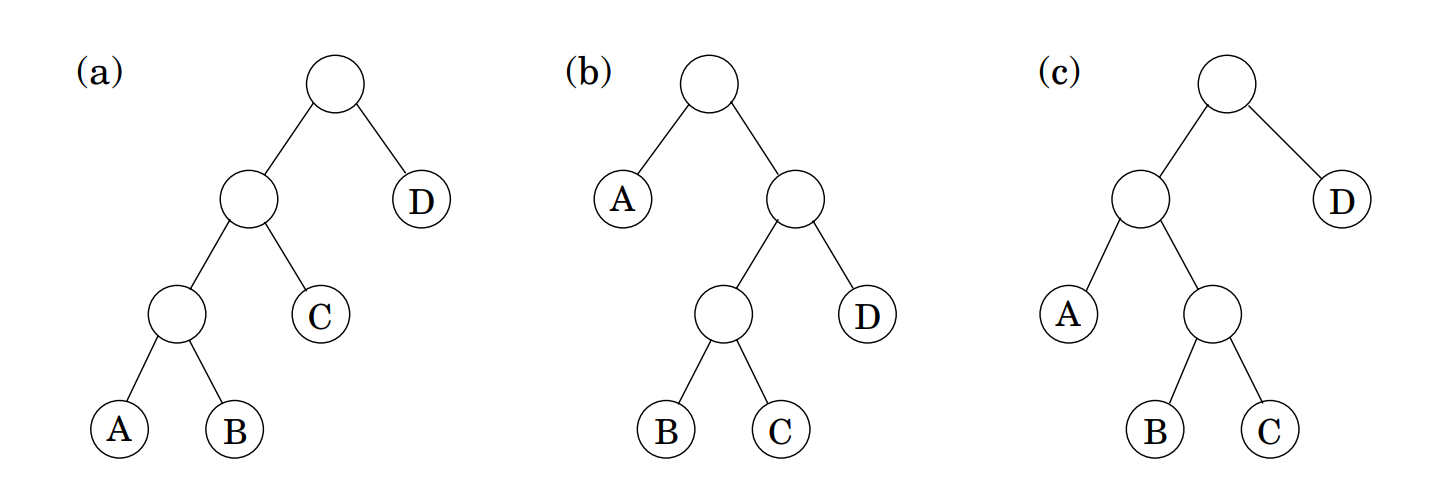

In [38]:
display(Image("img/cmm_tree.png", width=700))

The leftmost binary tree corresponds to the parenthesizations $((AB)C)D$, the middle corresponds to $A((BC)D)$ and the rightmost to $(A(BC))D$. The leaves correspond to the four matrices and the internal nodes corresponds to the intermediate products such as $AB$ or $(AB)C$ for the case of the left most tree. The root corresponds to the overall product.

### Top-down approach

We can also follow the steps laid out by {cite:p}`cormen2022introduction` for solving this dynamic programming problem.

#### 1. Characterize the structure of an optimal solution (parenthesization)

Suppose that we have an optimal parenthesization for the $n$ matrix product $P_{\text{opt}}=A_1A_2A_3...A_n$. Now suppose we take this solution and split it into two chains at $A_k$ such that we have $P_{\text{opt}}^L=A_1A_2...A_k$ and $P_{\text{opt}}^R=A_{k+1}A_{k+2}...A_n$ and clearly $P_{\text{opt}} = P_{\text{opt}}^LP_{\text{opt}}^R$. Since we know $P_{\text{opt}}$ has an optimal parenthesization then we also know that the parenthesization of $P_{\text{opt}}^L$ is optimal. Why is this the case? Well if it wasn't the case and there was another parenthesization that was optimal for $P_{\text{opt}}^L$ then we can use that same parenthesization in the overall product in $P_{\text{opt}}=A_1A_2A_3...A_n$ to make it more optimal. But this is a contradiction since we stated at the beginning that $P_{\text{opt}}$ is already optimal. Therefore if $P_{\text{opt}}=A_1A_2A_3...A_n$ is an optimal parenthesization then the parenthesizations for sub-chains of the chain when considered in isolation must also be optimal. For example if $P_{\text{opt}}=(A_1(A_2(A_3A_4)))$ then $(A_2(A_3A_4))$ must also be an optimal parenthesization for the produce $A_2A_3A_4$. 

This ***partially*** goes in the other direction as well: an optimal solution to parenthesizing $A_1A_2A_3...A_n$ can be constructed by splitting the chain into two parts and finding optimal parenthesizing of the two resulting chains and multiplying them together (combining the solutions). The problem is that we do not know *which* split, i.e. splitting at $k=1$, $k=2$ etc, is optimal so we have to try all of them much like the rod cutting problem. But as with rod cutting we will find that we can exploit the repeated occurrence of subproblems to drastically cut down the number of computations we must perform.




```{note}
:class: dropdown
I say it partially goes in the other direction because in general it is not true that all splits can yield an optimal solution. For example if $(A(B(C(EF)G)))$ is an optimal parenthesization we can certainly find instance where the optimal parenthesization of $ABC$ is not an optimal parenthesization for the overall chain when multiplied by the optimal parenthesization of $EDF$.
```

#### 2. Recursively define the value of an optimal solution

First for a problem of inputs size $n$, i.e. $P=A_1A_{2}...A_n$, we will define $A_{i:j}$ to be the matrix that results from computing $A_iA_{i+1}...A_j$ where $1\leq i \leq j \leq n$. We are given the dimensions of the matrices as a list $[m_0,m_1,...m_n]$ such that matrix $A_i$ is of shape $m_{i-1}\times m_i$. Let $s[i,j]$ be the minimum number of scalar multiplications needed to compute the matrix $A_{i:j}$ resulting from the chain $A_iA_{i+1}...A_j$. We want to find a parenthesization that results in $s[1,n]$ scalar multiplications since $s[1,n]$ the minimum number of scalar multiplications needed to compute the whole chain. There are 2 cases either

1) $i=j$ in which case we only have one matrix and the minimum number of scalar multiplications needed to compute it are 0 (we're not multiplying anything) so  $s[i,i]=0 \quad \forall i \in \{1,2,...,n\}$ 

$\qquad \qquad \qquad \Large{\textbf{or}}$

2) $i<j$ (we ignore cases where $i>j$ since they are covered) in which case we have the product $A_iA_{i+1}...A_j$ to compute. Suppose an optimal parenthesization splits the product at $A_k$ where $i \leq k < j$. Then $s[i,j]$ is equal to the minimum number of scalar multiplications to compute $A_{i:k}$, i.e. $s[i,k]$, plus the minimum number of scalar multiplications to compute $A_{k+1:j}$, i.e. $s[k+1,j]$, plus the number of scalar multiplications needed to multiply the two resulting matrices $A_{i:k}$ and $A_{k+1:j}$. The shape of $A_{i:k}$ will be $m_{i-1} \times m_k$ and the shape of $A_{k+1:j}$ will be $m_k \times m_j$ and so it will take $m_{i-1}m_km_j$ scalar multiplications to compute their product at a minimum. Thus we can express $s[i,j]$ as 

$$
s[i,j] = s[i,k] + s[k+1,j] + m_{i-1}m_km_j
$$

## Shortest paths

The Bellman-Ford algorithm for finding the shortest path between a node $s$ and another node $t$ in a graph and the Floyd-Warshall algorithm for finding the shortest path between all pairs of nodes in a graph can be understood as dynamic programming algorithms.  

## Practice problems

These are problems from chapter 6 of the DPV textbook.

### 6.1 Maximal Contiguous Subsequence

Given a list of numbers

$$
L_n = a_1,a_2,...,a_n
$$

we want to find the sum of the *contiguous* subsequence of maximal sum. This problem is nice since we are dealing with contiguous subsequences so there's no need to consider previous solutions to all previous subproblems.

The recurrence for this problem is

$$
T(i) = \max\{ T(i-1) + a_i, \quad a_i \} = \max\{ T(i-1), \quad 0 \} + a_i
$$

This essentially says the solution to subproblem $i$ will be constructed by either 1) appending $a_i$ to the end of the solution for the $i-1$-th subproblem or 2) only including $a_i$. This is very similar to the constraint we had for LIS i.e. $a_i$ must be included in the solution to subproblem $i$. Once we have the full array/table $T$ we simply find it's max value and this will be the value of the sum of the contiguous subsequence of maximal sum. Again the same logic applies here as for LIS: since the contiguous subsequence of maximal value must end with *one* of the elements from $L_n$ and we have solved for the contiguous subsequence of maximal sum that ends with $a_i$ $\forall i\in\{1,...,n\}$ we know at least *one* of the values in our table corresponds to the sum of the contiguous subsequence of maximal sum i.e. the one with the largest value.

The below algorithm has complexity $O(n)$ in both time and space. You could get this down to $O(1)$ space complexity by just keeping track of the maximum value as you make your way through the subproblems.

In [39]:
def p1(nums):
    if nums == []: # if empty list 
        return 0
        
    n = len(nums)
    sol = [0]*n
    sol[0] = nums[0] # the solution to the smallest non-trivial subproblem is simply nums[0] since it is the only element in the array

    for i in range(1, n):
        # the solution to subproblem i will either 
        # 1) be appending nums[i] to the end of the solution for subproblem i-1 (the previous smaller subproblem) OR
        # 2) the solution will just be the element nums[i] itself.
        # This follows from the constraint that this must be a contiguous subarray/subsequence
        if sol[i-1] + nums[i] > nums[i]: 
            sol[i] = sol[i-1] + nums[i]
        else:
            sol[i] = nums[i]
    
    return max(sol)

test = [5, 15, -30, 10, -5, 40, 10]
print(p1(test))

55


### 6.2 Hotel Stops

So the idea here is fairly straightforward. Given a sequence of $n$ hotels with distances $a_i$ from the starting point

$$
a_1,a_2,...,a_n.
$$
 
The subproblems are simply: what is the optimal sequence of stops for the sequence

$$
a_1,a_2,...,a_i \quad\text{Where $1\leq i \leq n$}
$$

that ends with the final stop $a_i$.

The solution to subproblem $i$ will either be 

1. Taking *one of* the optimal sequence of stops found for the previous smaller subproblems and then driving from the ending hotel of that solution to $a_i$. We compute the penalty for taking each route by adding the penalty for that subproblem solution with the penalty of driving from the final destination/hotel in that subproblem to the final hotel $a_i$ in our current subproblem. The latter term in the sum is computed as $\left(200-(a_i-a_j)\right)^2$ for previous subproblem $j$. If one of these routes yields a penalty lower than $(200-a_i)^2$ and it is the smallest penalty found after iterating over all past optimal routes then it is the optimal route for subproblem $i$. 

$\qquad \qquad \qquad \Large{\textbf{or}}$

2. Making no stops and just driving straight to the last hotel in which case the penalty is $(200-a_i)^2$.

whichever of these two options yields a lower total penalty is our solution.

The recurrence for this problem is thus

$$
T(i) = \min\left\{ \min_j\left\{ \left(200-(a_i-a_j)\right)^2 + T(j) \right\}, \quad (200-a_i)^2 \right\}
$$

In [13]:
def p2(seq):
    n = len(seq)
    # initialize baselines
    sols = [ [f"a{i+1}"] for i in range(n) ] # baseline for routes is we just drive straight to the last hotel with no stops
    opt_penalties = [ (200 - seq[i])**2 for i in range(n) ] # baseline for the penalty is the corresponding penalty calculated via (200-x)^2

    for i in range(n):
        for j in range(i):
            P = (200 - (seq[i] - seq[j]))**2 + opt_penalties[j]
            if P < opt_penalties[i]:
                opt_penalties[i] = P
                sols[i] = sols[j] + [ f"a{i+1}" ]
    
    return {"Optimal stop sequence": sols[-1], "Sequence penalty":opt_penalties[-1]}

func = lambda hotels: print(f"Solution for {hotels} \nis: {p2(hotels)}")

hotels = [ 100, 134, 147, 244, 288, 303 ]
func(hotels)
hotels = [ 190, 420, 550, 660, 670 ]
func(hotels)
hotels = [ 10, 200, 270, 430, 500 ]
func(hotels)

Solution for [100, 134, 147, 244, 288, 303] 
is: {'Optimal stop sequence': ['a3', 'a6'], 'Sequence penalty': 4745}
Solution for [190, 420, 550, 660, 670] 
is: {'Optimal stop sequence': ['a1', 'a2', 'a5'], 'Sequence penalty': 3500}
Solution for [10, 200, 270, 430, 500] 
is: {'Optimal stop sequence': ['a3', 'a5'], 'Sequence penalty': 5800}


The time complexity of this algorithm is $O(n^2)$ due to the doubly nested loops. It is possibly to get this down to $O(n\log_2{n})$ if we utilize a binary search to speed up the inner loop. We can utilize binary search since the hotels are sorted in order of increasing distance from the starting point. The space complexity is also $O(n^2)$ since we are storing the solution sequence for each subproblem meaning we will be storing arrays with $O(i)$ elements for each subproblem meaning in total we store at most 

$$
\sum_{i=1}^{n}i
$$

elements in memory. This is an arithmetic series whose sum is well known to be equal to 

$$
\frac{n(a_1+a_n)}{2}
$$
 
where $a_1$ and $a_n$ are the first and last terms in the series respectively which means this sum is equal to $n(1+n)/2 \in O(n^2)$.

### 6.3 Yuckdonald's

For subproblem $i$ the solution will be either

1. Opening a store at only location $i$ is optimal.

$\qquad \qquad \qquad \Large{\textbf{or}}$

2. Opening a location at location $i$ in addition to opening one at the optimal locations for *one of* the previous optimal solutions to the smaller subproblems is optimal. To check this we can simply loop over all previous optimal solutions and see if opening a store at location $i$ in addition to the stores already open for that optimal solution will result in more profit than only opening one store at location $i$. If we find such a previous solution $L_j$ then we must also check if the store at location $i$ is at least $k$ miles away from the store at position $j$ for that optimal solution and if it is then that is our optimal solution. 

The recurrence for this problem is this

$$
T(i) = \max\left\{ \max_j\left\{ p_i + T(j) \bigg\vert m_i-m_j \geq k\right\}, \quad p_i\right\}
$$

In [12]:
def p3(m, p, k):
    n = len(m)
    sols = [ 0 for i in range(n) ] # set the baseline to all 0
    sols[0] = p[0] # for subproblem 1 the optimal solution is trivial: open a location at location 1

    for i in range(n):
        sols[i] = p[i]
        for j in range(i):
            if p[i] + sols[j] > sols[i] and m[i] - m[j] >= k:
               sols[i] = p[i] + sols[j]
               

    return max(sols)

func = lambda m, p, k: print(f"Maximum profit for \nm={m} \np={p} \nk={k} \nis: {p3(m, p, k)}")

# Test cases from: https://gist.github.com/primaryobjects/1406b79f12db5320f0797792d8f73b04
m = [1,2,3,4,5,6]
p = [5,5,5,5,5,5]
k = 5
func(m,p,k)

m =[0, 5, 10, 15, 20]
p = [5,5,5,5,5]
k=5
func(m,p,k)

m = [ 10, 20, 25, 30, 40 ]
p = [ 100, 100, 101, 100, 100 ]
k = 10
func(m,p,k)

m = [ 0, 4, 8 ]
p = [ 10, 42, 31 ]
k = 5
func(m,p,k)

Maximum profit for 
m=[1, 2, 3, 4, 5, 6] 
p=[5, 5, 5, 5, 5, 5] 
k=5 
is: 10
Maximum profit for 
m=[0, 5, 10, 15, 20] 
p=[5, 5, 5, 5, 5] 
k=5 
is: 25
Maximum profit for 
m=[10, 20, 25, 30, 40] 
p=[100, 100, 101, 100, 100] 
k=10 
is: 400
Maximum profit for 
m=[0, 4, 8] 
p=[10, 42, 31] 
k=5 
is: 42


The time and space complexity are clearly $O(n^2)$ and $O(n)$ respectively. As a sanity check we can code a brute force algorithm to compute the answer of our test cases shown below.

In [42]:
def p3_brute_force(n, m, p, k):
    # Initialize the maximum profit
    max_profit = 0
    
    # Iterate over all subsets of the locations
    for subset in range(1 << n):  # 2^n possible subsets
        valid = True
        total_profit = 0
        last_location = -float('inf')  # Initialize last location as negative infinity
        
        # Check each location in the subset
        for i in range(n):
            # If the i-th bit is set in the subset, location i is included
            if subset & (1 << i):
                # Check if this location satisfies the distance constraint
                if m[i] - last_location >= k:
                    total_profit += p[i]  # Add the profit of location i
                    last_location = m[i]  # Update last location
                else:
                    valid = False
                    break  # Subset is invalid, so break out of loop
        
        # If the subset is valid and its profit is greater than the current max, update max_profit
        if valid:
            max_profit = max(max_profit, total_profit)
    
    return max_profit


m = [1,2,3,4,5,6]
p = [5,5,5,5,5,5]
k = 5
print(f"\nMaximum profit for test case 1 is: {p3_brute_force(len(m), m, p, k)}")

m =[0, 5, 10, 15, 20]
p = [5,5,5,5,5]
k=5
print(f"\nMaximum profit for test case 2 is: {p3_brute_force(len(m), m, p, k)}")

m = [ 10, 20, 25, 30, 40 ]
p = [ 100, 100, 101, 100, 100 ]
k = 10
print(f"\nMaximum profit for test case 3 is: {p3_brute_force(len(m), m, p, k)}")

m = [ 0, 4, 8 ]
p = [ 10, 42, 31 ]
k = 5
print(f"\nMaximum profit for test case 4 is: {p3_brute_force(len(m), m, p, k)}")


Maximum profit for test case 1 is: 10

Maximum profit for test case 2 is: 25

Maximum profit for test case 3 is: 400

Maximum profit for test case 4 is: 42


### 6.4 Dictionary lookup

So let's define our subproblem in words first:

$T(i)$ is $\text{True}$ if the substring $s[1...i]$ can be broken up into a sequence of valid words from our dictionary $D$ and is $\text{False}$ otherwise.

If we want to evaluate $T(i)$ and have found the solution for all subproblems of size $<i$ how would we do it? Well if the substring $s[1...i]$ can be broken into a sequence of valid words there will be some breaking point $j<i$ where the substring $s[1...j]$ will be able to be broken into a sequence of valid words and thus $T(j)=\text{True}$ and the remaining part of the string $s[j+1...i]$ will be a word from $D$. We should also check if the whole substring $s[1...i]$ is in $D$ which would mean there are no breaking points.

With this in mind for the recurrence lets try:

$$
T(i) = \bigvee_{j=0}^{i-1} (T(j) \wedge s[j+1...i] \in D) \quad \text{where} \quad 1\leq i \leq n
$$

With the base case $T(0)=\text{True}$ which will enable us to first check if the whole substring $s[1...i]$ is in $D$ since the first term in the clause, i.e. $T(0) \wedge s[1...i] \in D$, will now evaluate to $\text{True}$ only if the whole substring is in $D$.

In [80]:
# We use j-1 because python indexing starts at 0 instead of 1,
# but note that we dont use i+1 when indexing s despite this because we are starting i at 1 in the outer loop
def p4(s, D):
    n = len(s)
    T = [False]*(n+1)
    T[0] = True # base case
    back = [-1]*n # for backtracking
    for i in range(1, n+1):
        for j in range(1, i+1): 
            substr = s[j-1:i] 
            T[i] = T[i] or ( T[j-1] and (substr in D) )
            if T[i]:
                back[i-1] = j
    
    if T[-1]: # if string can be broken into words perform backtracking to find words
        words = ""
        start_break = back[n-1]
        for i in range(n-2, -1, -1):
            if back[i] != -1:
                end_break = back[i]
                words = " " + s[end_break:start_break] + words
                start_break = end_break
        words = s[0:start_break] + " " + words
        print(f"'{s}' can be broken up into: '{words}'")

    return T[-1]


func = lambda s, D: print(f"Can '{s}' be broken into a sequence of valid words from {D}? {'yes' if p4(s, D) else 'no'}")

s = "leetcode"
D = ["leet","code"]
func(s, D)

s = "itwasthebestoftimes"
D = ["it","was","the","best","of","times"]
func(s, D)

s = "ab"
D = ["a","b"]
func(s, D)

'leetcode' can be broken up into: 'leet  code'
Can 'leetcode' be broken into a sequence of valid words from ['leet', 'code']? yes
'itwasthebestoftimes' can be broken up into: 'it  was the best of times'
Can 'itwasthebestoftimes' be broken into a sequence of valid words from ['it', 'was', 'the', 'best', 'of', 'times']? yes
'ab' can be broken up into: 'a  b'
Can 'ab' be broken into a sequence of valid words from ['a', 'b']? yes


The problem says to assume checking if a word is in the dictionary $D$ is an $O(1)$ time operation so the time complexity of this algorithm is $O(n^2)$. If the dictionary lookups were not constant time but instead $O(n)$ time then the time complexity would be $O(n^3)$.

### 6.6 Trinary multiplication

This problem seems similar to chain matrix multiplication. 

### 6.7 Longest palindromic subsequence

Given a sequence

$$
s_n = a_1,a_2,a_3...,a_n
$$

The recurrence is thus

$$
L_i^s = \max\left\{ \max_j\left\{1+L_j^s| s_j=s_i\right\} ,\quad 1\right\}
$$

In [44]:
def p7():
    pass

### 6.8 Longest common substring

Since we must find the longest common *substring* this means the subsequences must be contiguous. 


In [45]:
def p8(nums1, nums2):
    L = []
   
    n = len(nums1)
    m = len(nums2)

    for i in range(n+1):
        L.append( [0]*(m+1))

    for i in range(2, n+1):
        for j in range(2, m+1):
            if nums1[i-1] == nums2[j-1] and nums1[i-2] == nums2[j-2]:
                L[i][j] = 1 + L[i-1][j-1] 
            else:
                L[i][j] = 1
    
    return L[n][m]

### 6.11 Longest common subsequence

Already solved above!

### 6.17 Making change

I think we have to assume all the inputs will be integers as we did with knapsack otherwise I'm not sure how to handle a table where one of the indices is a continuous value. This problem seems similar to knapsack with repetition since we have an unlimited supply of each denomination. I think we can either define the subproblems in terms of either a smaller subset of the possible coins, e.g. $T(i)$ is the boolean value corresponding to whether or not we can make change for $v$ using a subset of coins of denomination $X_i=\{x_1,...,x_i\}$, or in terms of smaller values of $v$, e.g. $T(i)$ is the boolean value corresponding to whether or not we can make change for $0\leq i\leq v$ using  the full set of coins of denomination $X=\{x_1,...,x_n\}$. The latter seems most straightforward to me in terms of how we could use solutions to smaller subproblems to find solutions to larger ones. For example suppose we want to see if we can make change for $i$ and we have determined whether we can make change or not for all values $<i$. We can
1) Look to see if there is a coin with denomination $i$ in $X$ and if so return $\text{True}$.

or

2) Look to see if we can make change for $i-1$ and $1$ and if so then we return $\text{True}$ if not then we return $\text{False}$ and see if we can instead make change for $i-2$ and $2$ and so on until we've tried up to $i-(i-1)$ and $i-1$. If *any one* of these is $\text{True}$ then we can in fact make change for $i$ so we will return $\text{True}$. 

Thus we can use following recurrence to describe this problem:

$$
T(i) = \left(\bigvee_{j} [T(i-j) \wedge T(j)]\right) \vee \alpha(i)\\
\text{where} \quad 2 \leq i \leq v, \quad 1 \leq j < i \quad \text{and} \\
\alpha(i)=\begin{cases} 
      \text{True} &\quad\text{if}\quad i \in X\\
      \text{False}  &\quad\text{otherwise} \\
   \end{cases}
$$

and the base cases are $T(0)=\text{True}$, since we can always make change for nothing, and 

$$

T(1)=\begin{cases} 
      \text{True} &\quad\text{if}\quad 1 \in X\\
      \text{False}  &\quad\text{otherwise} \\
   \end{cases}\\
$$

Note that the $\bigvee$ means we perform an OR over the and clauses

$$
\begin{align*}
&\bigvee_{j=0}^i T(i-j) \wedge T(j) \\
&= (T(i) \wedge T(0)) \vee (T(i-1) \wedge T(1)) \vee \cdots \vee (T(0) \wedge T(i))
\end{align*}
$$

so if any one of them is $\text{True}$ the whole expression evaluates to $\text{True}$. And in fact we actually just need to let $j$ run from 1 to at most $\left\lceil\frac{i}{2}\right\rceil$ due to the symmetric nature of the AND clause (notice the first and last terms of the clause are logically equivalent $T(i) \wedge T(0) = T(0) \wedge T(i)$).

For each value of $i$ we solve for we have to examine all elements in the set $X=\{x_1,...,x_n\}$ and there are $v$ values of $i$ so our time complexity is $O(nv)$. Note that like knapsack this is exponential in *the number of bits* needed to represent $v$ i.e. $\log_2{v}$.

In [10]:
def p17(v, X):
    if len(X) == 0 and v > 0: # edge cases
        return False
    if len(X) == 0 and v == 0:
        return True
    
    T = [False]*(v+1)
    T[1] = 1 in X
    for i in range(2, v+1):
        T[i] = i in X # baseline is: is there a coin with denomination i in X? Complexity is O(n)
        for j in range(i):
            T[i] = T[i] or ( T[i-j] and T[j] )
    
    # TODO Implement backtracing

    return T[-1]

func = lambda X, v: print(f"Can we make change for {v} using {X}? {'yes' if p17(v, X) else 'no'}")

X = [1,4,6,8,3]
v = 77
func(X, v)

X = [2,8,9]
v = 7
func(X, v)

X = [5, 10]
v = 15
func(X, v)

X = [5, 10]
v = 12
func(X, v)

X = [5, 10]
v = 25
func(X, v)

X = [5]
v = 25
func(X, v)

Can we make change for 77 using [1, 4, 6, 8, 3]? yes
Can we make change for 7 using [2, 8, 9]? no
Can we make change for 15 using [5, 10]? yes
Can we make change for 12 using [5, 10]? no
Can we make change for 25 using [5, 10]? yes
Can we make change for 25 using [5]? yes


### 6.18 Making change 2

Now for this variation of the problem we can use each coin *at most once* so it is similar to knapsack without repetition. 

For our subproblem lets define it as: 

$T(i,s)$ is $\text{True}$ if we can make change for $0\leq s \leq v$ using the first $0\leq i \leq n$ coins $X_i=\{x_1,...,x_i\}$ using each coin at most once and is $\text{False}$ otherwise.

For the coin $x_i$, if $x_i\leq s$, there are two options

1) We use $x_i$ in our change and thus need to use the first $i-1$ coins to make change for $s-x_i$ so we check the truth value of entry $K(i-1,s-x_i)$.

or

2) We do not use $x_i$ and thus must use the first $i-1$ coins to make change for $s$ without $x_i$ in which case we check the truth value of the entry $K(i-1,s)$.

And if $x_i>s$ then we can't include $x_i$ so we must use the first $i-1$ coins to make change for $s$ so we look at the truth value of the entry K(i-1,s)$. 

The following is the recurrence: 

$$
T(i,s) = \begin{cases}
T(i-1, s-x_i) \vee T(i-1, s) & \quad \text{if} \quad  x_i \leq s \\
T(i-1, s) & \quad \text{if} \quad x_i > s
\end{cases}
$$

with the base cases being

$$
T(0,0) = \text{True} \\
T(0,s) = \text{False} \quad \text{where} \quad 0 < s \leq v \\
T(i,0) = \text{True} \quad \text{where} \quad 0 < i \leq n \\
$$
The first base case follows because we can make change for $0$ given a set of $0$ coins. The second base case follows because we can not make change for $s>0$ given $0$ coins. The third base case comes from the fact that we can always make change for a value of $v=0$ given any set of coins since we just need to use the empty set. Our answer will be given by $T(n,v)$ and our time complexity is $O(nv)$.

In [8]:
def p18(v, X):
    
    n = len(X)
    T = [] # will be an (n+1) by (v+1) table +1 to account for v=0 and X={}
    for i in range(n+1): # set base cases
        T.append([])
        for s in range(v+1):
            if s == 0 and i == 0: # we can always make change for nothing (s=0)
               T[i].append(True)
            elif s == 0 and i != 0: # we can always make change for nothing (s=0)
               T[i].append(True)
            elif s != 0 and i == 0: # we can never make change for s>0 given no coins
               T[i].append(False)
            else: # set non-base case entires to None
               T[i].append(None) 


    for i in range(1, n+1):
        x_i = X[i-1]
        for s in range(1, v+1):
            if x_i <= s:
                T[i][s] = T[i-1][s-x_i] or T[i-1][s]
            elif x_i > s:
                T[i][s] = T[i-1][s]
    
    return T[n][v]

# lambda func to print output of test cases
func = lambda X, v: print(f"Can we make change for {v} using each coin at most once from {X}? {'yes' if p18(v, X) else 'no'}")

X = [5, 10]
v = 12
func(X,v)

X = [5] # can make change if we can use each coin as many times as we want but not at most once
v = 15
func(X,v)

X = [5, 2, 8] # can make change using 8+2+5
v = 15
func(X,v)

X = [5, 2, 8, 2] # can make change using 8+2+5
v = 15
func(X,v)

X = [1, 5, 10, 20] # from the book
v = 16
func(X,v)

X = [1, 5, 10, 20] # from the book
v = 31
func(X,v)

X = [1, 5, 10, 20] # from the book
v = 40
func(X,v)

Can we make change for 12 using each coin at most once from [5, 10]? no
Can we make change for 15 using each coin at most once from [5]? no
Can we make change for 15 using each coin at most once from [5, 2, 8]? yes
Can we make change for 15 using each coin at most once from [5, 2, 8, 2]? yes
Can we make change for 16 using each coin at most once from [1, 5, 10, 20]? yes
Can we make change for 31 using each coin at most once from [1, 5, 10, 20]? yes
Can we make change for 40 using each coin at most once from [1, 5, 10, 20]? no


### 6.19 Making change 3

In this variation of the problem we again have an unlimited number of each coin in $X=\{x_1,...x_n\}$ but we can use *at most* $k$ coins total to make change for $v$. The problem says to give an *efficient* dynamic programming algorithm for this problem which leads me to think that we can't have a complexity that depends on $v$ (or grows faster than logarithmically in $v$) like we did for the other two variations. 

$T(i,j)$ is $\text{True}$ if we can make change for $v$ using *exactly* $j$ coins from $X_i=\{x_1,\dots,x_i\}$ and $\text{False}$ otherwise.

### 6.20 Optimal binary search trees

### 6.26 Sequence alignment

In [47]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Sep 07 2024

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

sympy: 1.12

